In [702]:
%pylab inline
indir = '/mnt/store1/oliverphilcox/3PCF_SE/3pcf_summed_output_n15_l8.npz'
n=15
l=8
m=l+1

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm', 'mat']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Add normalization

In [861]:
inv_phi_true = np.loadtxt('/mnt/store1/oliverphilcox/3PCF/Normed2BinCorrectionFactor_n15_11.txt')
inv_phi_used = np.loadtxt('/mnt/store1/oliverphilcox/3PCF/NormedBinCorrectionFactor_n15_11.txt')
corr_factor = np.mean(inv_phi_used[:,0]/inv_phi_true[:,0])

#### Load first integral part

# 1) Check why cell acceptances increase but particle acceptances are very low

# 2) Why are two 3-point terms different?

In [863]:
def symmetrize(mat):
    """ Add in symmetries to matrices """
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)//m):
        a = i//n
        b = i%n
        for j in range(len(mat)//m):
            c = j//n
            d = j%n
            # Add to all relevant bins
            these_mat = mat[i*m:(i+1)*m,j*m:(j+1)*m]*0.25
            out_mat[(a*n+b)*m:(a*n+b)*m+m,(c*n+d)*m:(c*n+d)*m+m]+=these_mat
            out_mat[(b*n+a)*m:(b*n+a)*m+m,(c*n+d)*m:(c*n+d)*m+m]+=these_mat
            out_mat[(b*n+a)*m:(b*n+a)*m+m,(d*n+c)*m:(d*n+c)*m+m]+=these_mat
            out_mat[(a*n+b)*m:(a*n+b)*m+m,(d*n+c)*m:(d*n+c)*m+m]+=these_mat
    return 0.5*(out_mat+out_mat.T)

In [864]:
def plotter(mat,rmax=0,perc=99,vmax=np.inf):
    if vmax==np.inf:
        vmax=np.percentile(mat,perc)
    plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
    plt.colorbar();
    if rmax==0:
        rmax=len(mat)
    plt.ylim([-0.5,rmax-0.5])
    plt.xlim([-0.5,rmax-0.5])

In [865]:
def rebinner(mat):
    out_mat = np.zeros_like(mat)
    for i in range(m):
        for j in range(m):
            out_mat[i*n*n:(i+1)*n*n,j*n*n:(j+1)*n*n]=mat[i::m,j::m]
    return out_mat

In [866]:
dat = np.load(indir)
print(dat.f.n_runs)

150


In [867]:
total_counts = dat.f.tot0

In [868]:
print("Triples: %.1e Quads: %.1e, Quints: %.1e, Hexes: %.1e"%(total_counts[0],total_counts[1],total_counts[2],total_counts[3]))

Triples: 6.5e+11 Quads: 3.6e+12, Quints: 2.0e+13, Hexes: 1.1e+14


In [869]:
bins_r = np.loadtxt('/mnt/store1/oliverphilcox/3PCF/SE_binning_n15.csv')

In [870]:
print('Radial Bins')
print(bins_r[:,0])
print(bins_r[:,1])
delta_r = bins_r[-1,0]-bins_r[-2,0]

Radial Bins
[ 30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160.
 170.]
[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180.]


In [871]:
#norm2 = pow(norm,2)
c30=dat['c30']*corr_factor**2
c40=dat['c40']*corr_factor**2
c50=dat['c50']*corr_factor**2
c60=dat['c60']*corr_factor**2
c31=dat['c31']*corr_factor**2
c41=dat['c41']*corr_factor**2
c51=dat['c51']*corr_factor**2
c61=dat['c61']*corr_factor**2
dat.close()
c3=c30+c31
c4=c40+c41
c5=c50+c51
c6=c60+c61

In [872]:
c3s=symmetrize(c3)
c4s=symmetrize(c4)
c5s=symmetrize(c5)
c6s=symmetrize(c6)

In [873]:
c60c=compression(symmetrize(c60))
c61c=compression(symmetrize(c61))

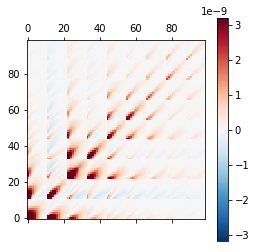

In [874]:
plotter(c61c)

(0, 55)

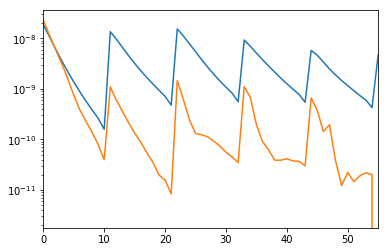

In [995]:
plt.plot(np.diag(c61c))
plt.plot(np.diag(c60c))
plt.yscale('log')
plt.xlim([0,55])

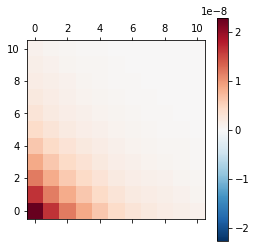

In [876]:
plotter(c60c,rmax=11,perc=100)

## Use SE compression

In [877]:
good_r_bins=[]
for b1 in range(n):
    for b2 in range(n):
        r1=bins_r[b1,0]
        r2=bins_r[b2,0]
        if (r2>=3*delta_r) and (r2<r1-3*delta_r):
            good_r_bins.append(b1)
good_r_bins = np.unique(np.asarray(good_r_bins))
n_g = len(good_r_bins)
min_r_bin = min(good_r_bins)

In [878]:
def compression(mat):
    comp_mat = np.zeros([n_g*m,n_g*m])
    den = np.zeros([n_g*m,n_g*m])

    all_v = 4.*np.pi*(bins_r[:,1]**3-bins_r[:,0]**3)/3

    for i in range(len(mat)):
        l = i%m
        b1 = (i//m)//n
        r1 = bins_r[b1,0]
        if b1<min_r_bin:
            continue
        b2 = (i//m)%n
        r2 = bins_r[b2,0]
        if (r2>=3*delta_r) and (r2<r1-3*delta_r):
            v_b2 = all_v[b2]

            for j in range(len(mat)):
                l2 = j%m
                b3 = (j//m)//n
                r3 = bins_r[b3,0]
                if b3<min_r_bin:
                    continue
                b4 = (j//m)%n
                r4 = bins_r[b4,0]
                if (r4>=3*delta_r) and (r4<r3-3*delta_r):
                    v_b4 = all_v[b4]

                    comp_mat[l*n_g+b1-min_r_bin,l2*n_g+b3-min_r_bin]+=mat[i,j]*v_b2*v_b4
                    den[l*n_g+b1-min_r_bin,l2*n_g+b3-min_r_bin]+=v_b2*v_b4

    comp_mat/=den
    return comp_mat

In [879]:
def reduce(mat):
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)):
        for j in range(len(mat)):
            out_mat[i,j]=mat[i,j]/np.sqrt(mat[i,i]*mat[j,j])
    return out_mat

In [880]:
c3se=compression(c3s)
c4se=compression(c4s)
c5se=compression(c5s)
c6se=compression(c6s)
c6se0 = compression(symmetrize(c60))
c6se1 = compression(symmetrize(c61))

In [881]:
ct = c3+c4+c5+c6
cts = symmetrize(ct)#-c60)
ctc = compression(cts)

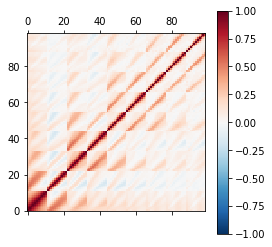

In [882]:
plotter(reduce(ctc))

## Load Data

In [883]:
mm=0 # min matrix element
nn=44 # max matrix element
c_mock = np.load('/mnt/store1/oliverphilcox/3PCF_SE/data_cov_matrix.npz')['cov'][mm:nn,mm:nn]
n_mock = np.load('/mnt/store1/oliverphilcox/3PCF_SE/data_cov_matrix.npz')['n_mocks']
this_ctc = ctc[mm:nn,mm:nn]

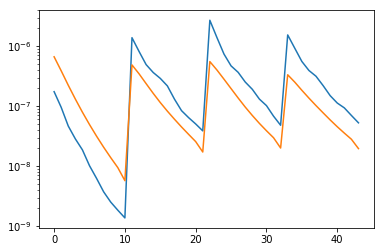

In [992]:
plt.plot(np.diag(c_mock))
plt.plot(np.diag(c6se1[mm:nn,mm:nn])*36)
plt.yscale('log')

In [899]:
np.loadtxt('/mnt/store1/oliverphilcox/3PCF/NormedBinCorrectionFactor_n15_11.txt').shape

(225, 7)

In [900]:
def model_cov(rescale,alpha,use_60=False):
    return rescale*(c6se0+use_60*c6se1+c5se*alpha+c4se*alpha**2+c3se*alpha**3)[mm:nn,mm:nn]

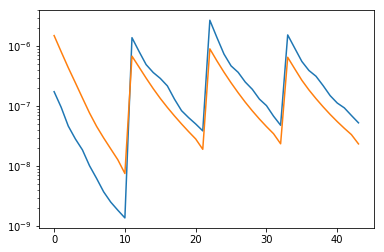

In [916]:
plt.plot(np.diag(c_mock))
plt.plot(np.diag(model_cov(30,1,True)))
plt.yscale('log')

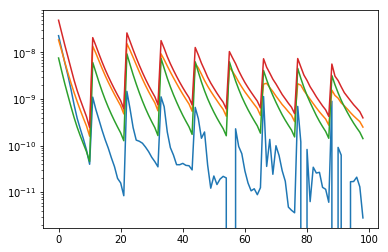

In [917]:
plt.plot(np.diag(c6se0))
plt.plot(np.diag(c6se1))
plt.plot(np.diag(c5se))
plt.plot(np.diag(c6se0+c6se1+c5se))
plt.yscale('log')

In [918]:
def KL_div(par):
    rescale,alpha=par
    prec = np.linalg.inv(model_cov(rescale,alpha,True))
    slog1 = np.linalg.slogdet(c_mock)
    slog2 = np.linalg.slogdet(prec)
    if slog1[0]<0:
        return np.inf
    if slog2[0]<0:
        return np.inf
    return 0.5*(np.trace(np.matmul(prec,c_mock))-slog1[1]-slog2[1])

In [969]:
from scipy.optimize import minimize
x=minimize(KL_div,[10,1])

In [970]:
x.x

array([49.66621647,  1.24541463])

In [960]:
flat_r=bins_r[min_r_bin:].mean(axis=1)**2
all_r = np.concatenate([flat_r for i in range(len(c_mock)//len(flat_r))])
r_mat = np.matmul(all_r.reshape(-1,1),all_r.reshape(1,-1))

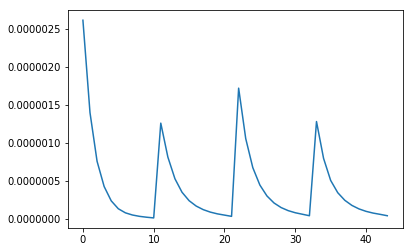

In [961]:
plt.plot(np.diag(model))

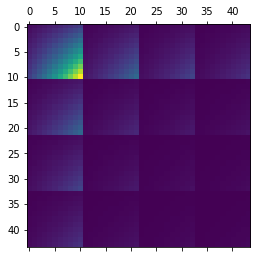

In [962]:
plt.matshow(r_mat/leg_mat)

In [963]:
legendre_norm = np.asarray([[2*p+1 for _ in range(len(flat_r))] for p in range(len(c_mock)//len(flat_r))]).ravel()
leg_mat = np.matmul(legendre_norm.reshape(-1,1),legendre_norm.reshape(1,-1))

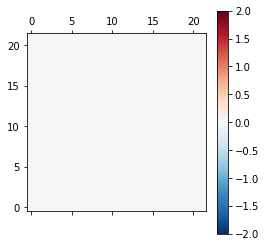

In [964]:
plotter(psi_model*leg_mat,rmax=22,vmax=2)

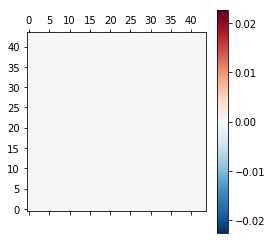

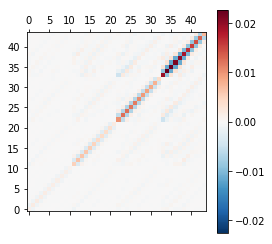

In [965]:
D = (len(c_mock)+1)/(n_mock-1)
psi_mock = (1.-D)*np.linalg.inv(c_mock)/r_mat**1.5

model = model_cov(x.x[0],x.x[1],True)
psi_model = np.linalg.inv(model)/r_mat**1.5

vmax = np.percentile(np.abs((psi_model*leg_mat).ravel()),99.99)
plotter(psi_mock*leg_mat,vmax=vmax,rmax=nn)
plotter(psi_model*leg_mat,vmax=vmax,rmax=nn)

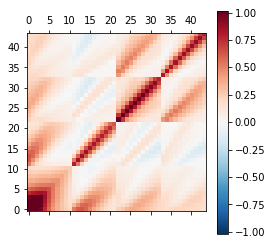

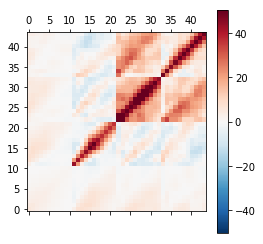

In [966]:
plotter(model*r_mat)
plotter(c_mock*r_mat)

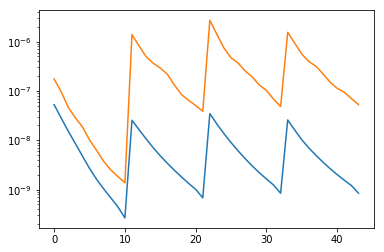

In [980]:
plt.plot(np.diag(model))
plt.plot(np.diag(c_mock))
plt.yscale('log')

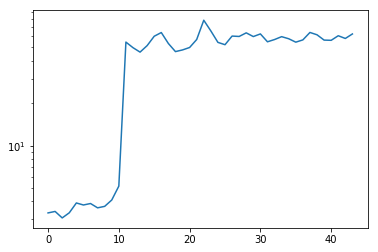

In [996]:
plt.plot(np.diag(c_mock)/np.diag(model))
plt.yscale('log')

# $\ell = 0$ term should be easiest since no angles!

## Why is c3 not well converged?

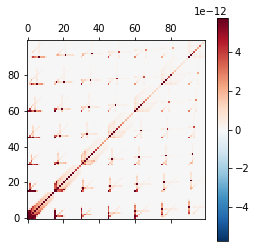

In [1061]:
plotter(symmetrize(c31)[::m,::m][:100,:100])

(-0.1, 0.1)

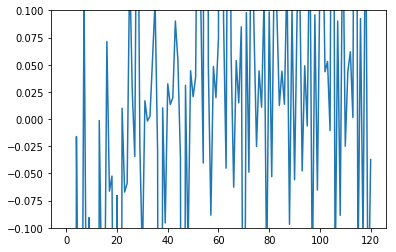

In [1072]:
plt.plot(np.diag(symmetrize(c30)[:121,:121])/np.diag(symmetrize(c31)[:121,:121])-1)
plt.ylim([-0.1,0.1])

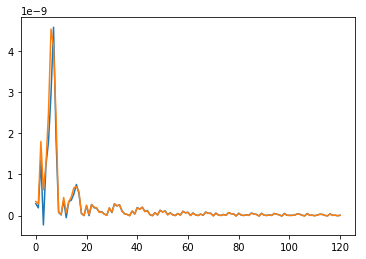

In [1071]:
plt.plot(np.diag(symmetrize(c30)[:121]))
plt.plot(np.diag(symmetrize(c31)[:121]))

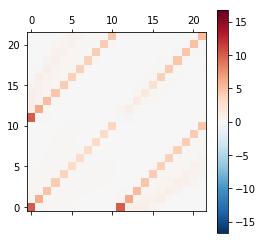

In [1015]:
plotter(c3se[mm:nn,mm:nn]*r_mat**1.5,rmax=22)

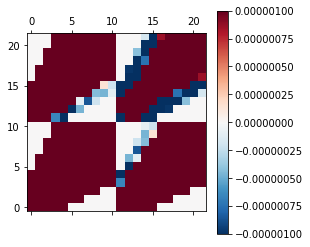

In [1009]:
plotter(c3se[mm:nn,mm:nn]*r_mat,rmax=22,vmax=1e-6)

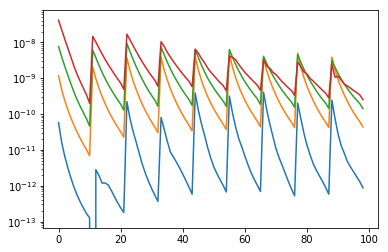

In [1001]:
plt.plot(np.diag(c3se))
plt.plot(np.diag(c4se))
plt.plot(np.diag(c5se))
plt.plot(np.diag(c6se))
plt.yscale('log');

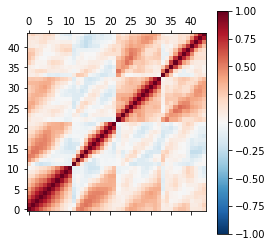

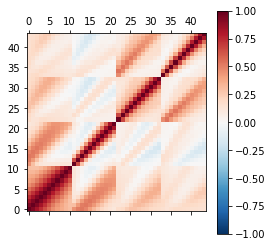

In [983]:
plotter(reduce(c_mock))
plotter(reduce(model))

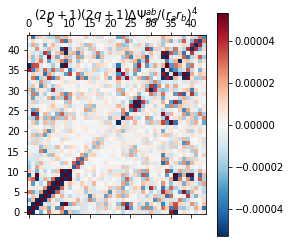

In [952]:
plotter((psi_mock-psi_model)*leg_mat,rmax=nn)
plt.title(r'$(2p+1)(2q+1)\Delta \Psi^{ab}_{pq}/(r_ar_b)^4$');

## Plot discriminant

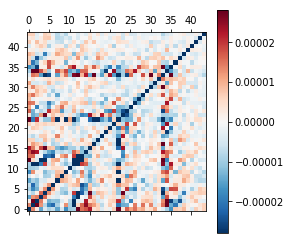

In [941]:
chol_mat = np.linalg.cholesky(c_mock)
disc = np.matmul(chol_mat.T,np.matmul(psi_model*r_mat,chol_mat))-np.eye(len(chol_mat))
plotter(disc,rmax=nn)

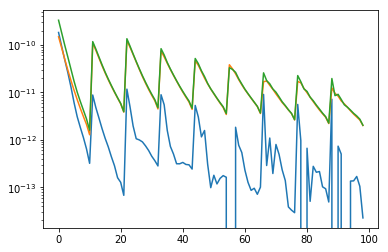

In [338]:
plt.plot(np.diag(c6se0))
plt.plot(np.diag(c6se1))
plt.plot(np.diag(c6se0+c6se1))
plt.yscale('log');

In [339]:
r_all = np.concatenate([bins_r[min_r_bin:].mean(axis=1)**4/1e4 for _ in range(m)])
r_mat = np.matmul(r_all.reshape(-1,1),r_all.reshape(1,-1))

## check matrix normalizations?

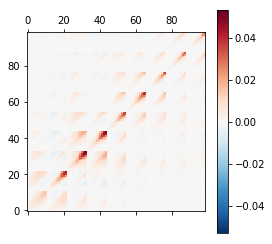

In [340]:
plotter((c3se+c4se+c5se+c6se1)*r_mat,rmax=99,perc=99.99)

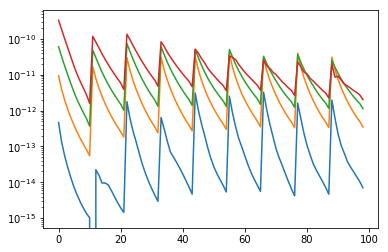

In [341]:
plt.plot(np.diag(c3se))
plt.plot(np.diag(c4se))
plt.plot(np.diag(c5se))
plt.plot(np.diag(c6se))
plt.yscale('log')

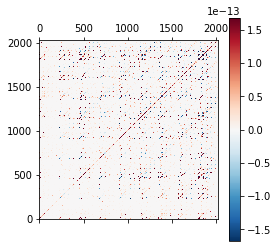

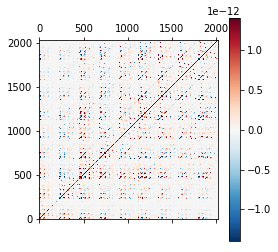

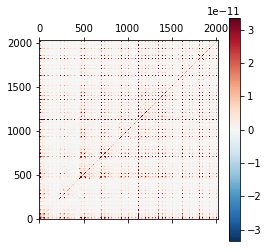

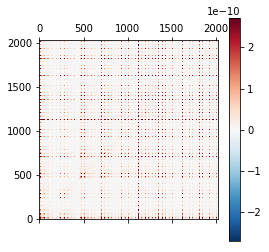

In [342]:
plotter(rebinner(c3s))
plotter(rebinner(c4s))
plotter(rebinner(c5s))
plotter(rebinner(c6s))

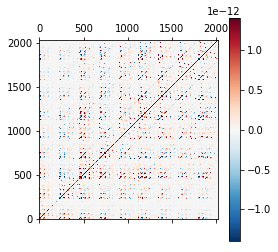

In [343]:
plotter(rebinner(c4s))

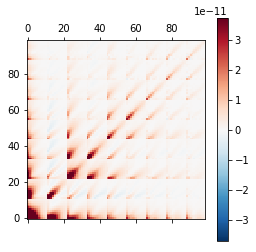

In [344]:
plotter(c6se)

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


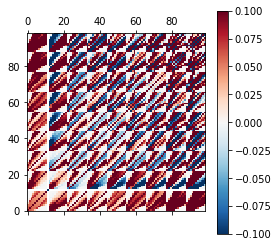

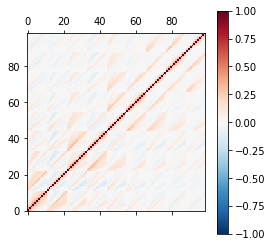

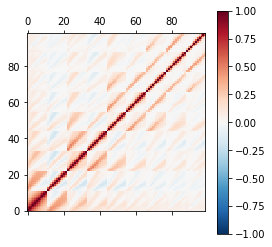

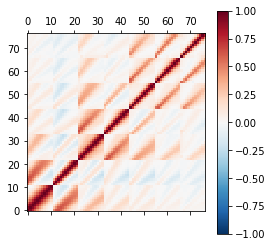

In [345]:
plotter(reduce(c3se))
plotter(reduce(c4se))
plotter(reduce(c5se))
plotter(reduce(c6se1),vmax=1,rmax=77)

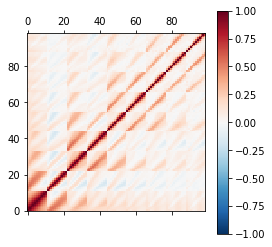

In [346]:
plotter(reduce(c5se+c4se+c3se+c6se))

**Difference between two C3 estimates**~

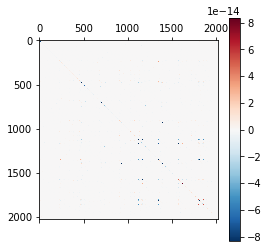

In [347]:
mat=rebinner(symmetrize(c30-c31))
vmax=np.percentile(rebinner(symmetrize(c30)),99.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
plt.colorbar();

In [348]:
tot_mat = symmetrize(c3+c4+c5+c6)

## Total Matrix

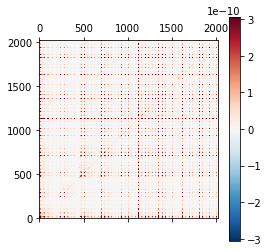

<Figure size 432x288 with 0 Axes>

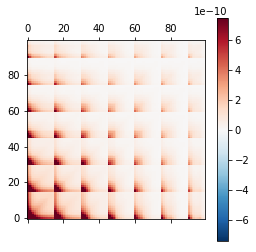

In [349]:
plotter(rebinner(symmetrize(tot_mat)))
plt.figure()
plotter(rebinner(symmetrize(tot_mat))[:100,:100])

In [352]:
b30=np.loadtxt(indir+'binct_c3_n%d_l%d_0_full.txt'%(n,l))
b40=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b50=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b60=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b31=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b41=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b51=np.loadtxt(indir+'binct_c5_n%d_l%d_0_full.txt'%(n,l))
b61=np.loadtxt(indir+'binct_c6_n%d_l%d_0_full.txt'%(n,l))

OSError: /mnt/store1/oliverphilcox/3PCF_SE/3pcf_summed_output_n15_l8.npzbinct_c3_n15_l8_0_full.txt not found.

**6-point Sampling**

In [353]:
plotter(rebinner(symmetrize(b60)))
plotter(rebinner(symmetrize(b61)))

NameError: name 'b60' is not defined

**3 Point**

(0, 300)

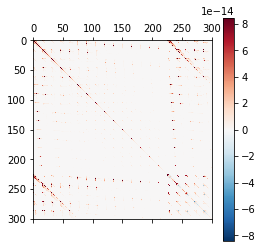

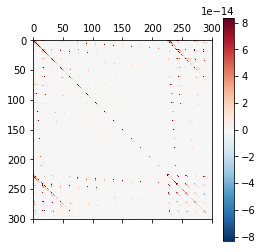

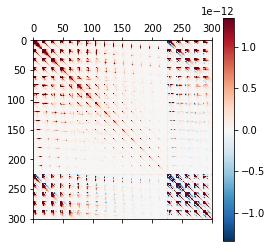

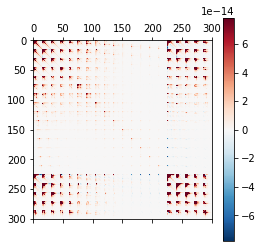

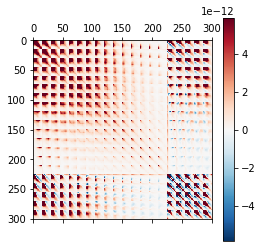

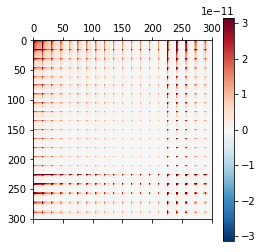

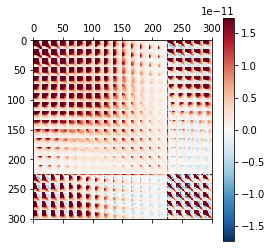

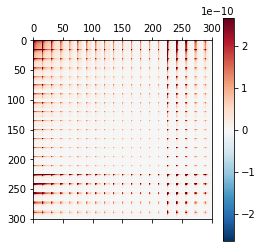

In [354]:
plotter(rebinner(symmetrize(c31)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c30)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c41)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c40)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c51)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c50)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c61)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c60)));plt.ylim([300,0]);plt.xlim([0,300])

In [355]:
def collapse_axes(mat,c_bin,d_bin):
    new_mat = np.zeros([m,m,n,n])
    for i in range(len(mat)):
        p_bin = i%m
        a_bin = (i//m)//n
        b_bin = (i//m)%n
        for q_bin in range(m):
            new_mat[p_bin,q_bin,a_bin,b_bin] = mat[i,c_bin*n+d_bin*m+q_bin]
    return new_mat

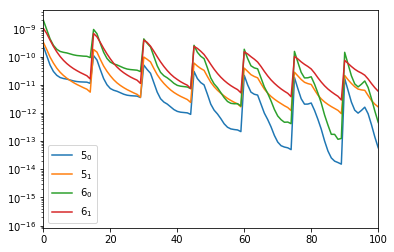

In [356]:
plt.plot(np.diag(rebinner(symmetrize(c50)))[:n*n],label=r'$5_0$')
plt.plot(np.diag(rebinner(symmetrize(c51)))[:n*n],label=r'$5_1$')
plt.plot(np.diag(rebinner(symmetrize(c60)))[:n*n],label=r'$6_0$')
plt.plot(np.diag(rebinner(symmetrize(c61)))[:n*n],label=r'$6_1$')
plt.legend();plt.xlim([0,100])
plt.yscale('log');

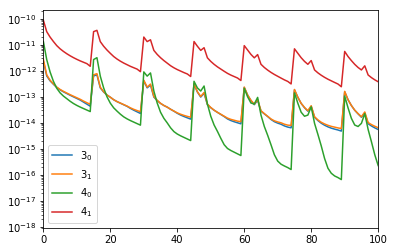

In [357]:
plt.plot(np.diag(rebinner(symmetrize(c30)))[:n*n],label=r'$3_0$')
plt.plot(np.diag(rebinner(symmetrize(c31)))[:n*n],label=r'$3_1$')
plt.plot(np.diag(rebinner(symmetrize(c40)))[:n*n],label=r'$4_0$')
plt.plot(np.diag(rebinner(symmetrize(c41)))[:n*n],label=r'$4_1$')
plt.legend();plt.xlim([0,100])
plt.yscale('log');

In [358]:
def variance(mat):
    out_mat = np.zeros([m,n,n])
    for p in range(m):
        for i in range(n):
            for j in range(n):
                out_mat[p,i,j]=mat[(i*n+j)*m+p,(i*n+j)*m+p]
    return out_mat

In [359]:
collapsed_mat = collapse_axes(tot_mat,5,7)
collapsed_mat.shape

(9, 9, 15, 15)

In [360]:
def collapse_axes_all_corr(mat,c_bin,d_bin):
    new_mat = np.zeros([n*m,n*m])
    for i in range(len(mat)):
        p_bin = i%m
        a_bin = (i//m)//n
        b_bin = (i//m)%n
        for q_bin in range(m):
            new_mat[p_bin*n+a_bin,q_bin*n+b_bin] += mat[i,c_bin*n*m+d_bin*m+q_bin]
    # Now compute correlation matrix
    corr_mat = np.zeros([n*m,n*m])
    for i in range(len(corr_mat)):
        p_bin = i//n
        a_bin = i%n
        for j in range(len(corr_mat[0])):
            q_bin = j//n
            b_bin = j%n
            corr_mat[p_bin*n+a_bin,q_bin*n+b_bin]=new_mat[p_bin*n+a_bin,q_bin*n+b_bin]/np.sqrt(new_mat[p_bin*n+a_bin,q_bin*n+a_bin]*new_mat[p_bin*n+b_bin,q_bin*n+b_bin])
    return corr_mat

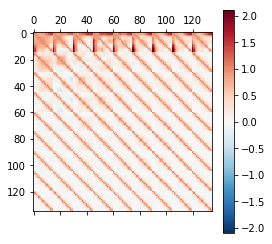

In [361]:
collapsed_mat = collapse_axes_all_corr(tot_mat,5,7)
vmax=np.percentile(collapsed_mat,99.9)
plt.matshow(collapsed_mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
#plt.title(r'$C_{%d%d}$'%(2*i,2*j))
plt.colorbar();

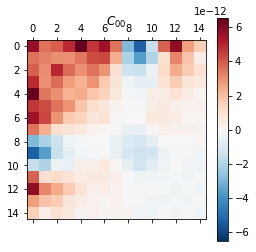

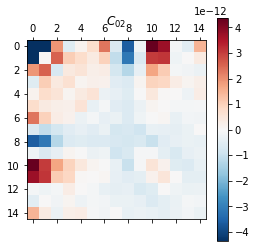

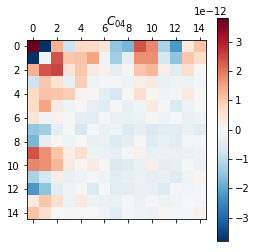

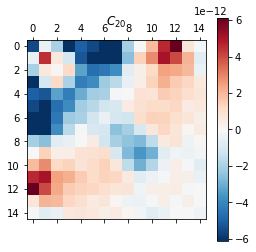

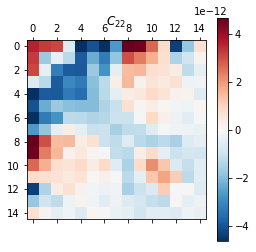

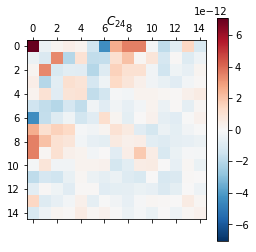

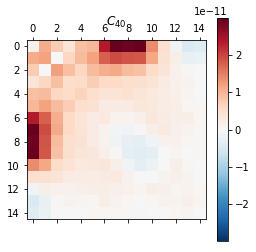

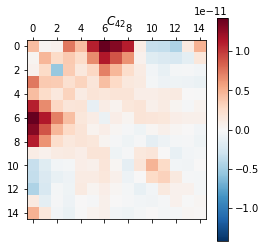

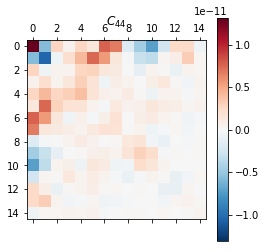

In [362]:
collapsed_mat = collapse_axes(tot_mat,5,2)
for i in range(3):
    for j in range(3):
        vmax=np.percentile(collapsed_mat[i,j],99.9)
        plt.matshow(collapsed_mat[i,j],vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
        plt.title(r'$C_{%d%d}$'%(2*i,2*j))
        plt.colorbar();